In [40]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from imp import reload
from scipy.stats import entropy
%matplotlib inline

import numba

from info_measures import dataset_generators as dg

In [14]:
# Load and remove zeros
mnist = input_data.read_data_sets('.', one_hot=True, validation_size=0, reshape=False)
X = mnist.train.images
X = X[:,2:-2:2,2:-2:2]

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [15]:
reload(dg)

dg_mnist = dg.ImageGenerator(X, grow_axis=2)

In [16]:
print(dg_mnist.X.shape)
print(dg_mnist.symmetry_axes)

(60000, 12, 12, 1)
[1, 2]


In [18]:
dim = 4
perp_dim = 7
samples = dg_mnist.sample_data(dim, perp_dim=perp_dim)

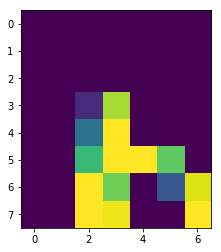

In [19]:
plt.imshow(samples[0].reshape(2*dim, perp_dim))

In [161]:
reload(dg)
dg_vec = dg.VectorSpaceGenerator(X)

In [162]:
xp = dg_vec.sample_data(grow_dim=7, n_samples_per_image=2)

In [163]:
%timeit dg_vec.sample_data(grow_dim=3, n_samples_per_image=2)

1.09 s ± 33.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


0.175875533019 0.346391780305
0.177387134417 0.347575479043
0.178422134461 0.347736324142
0.175914356545 0.346134417311
0.17716229783 0.347322213501
0.177745042931 0.347849328624
0.177300663807 0.347370887116
0.176891970992 0.347037331328
0.178470075637 0.348720587188
0.177068670352 0.347278185371
0.177475141014 0.34732641963
0.175428049354 0.345657776366
0.176055696402 0.346248996269
0.175498800965 0.345968070343


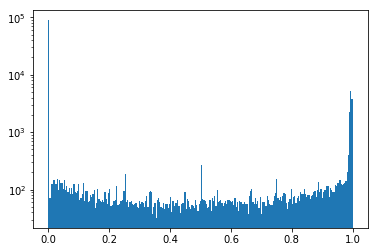

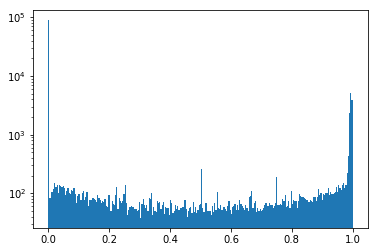

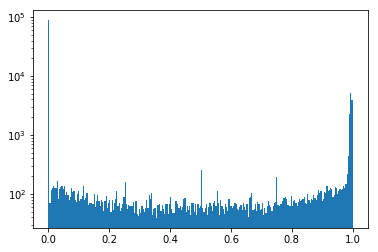

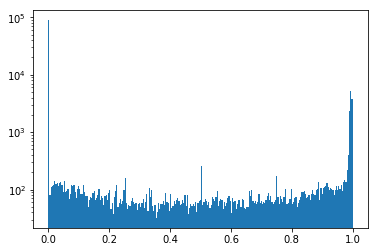

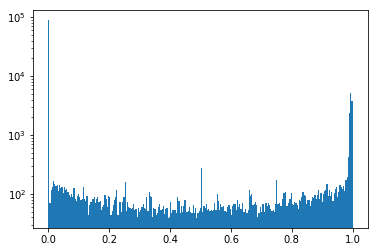

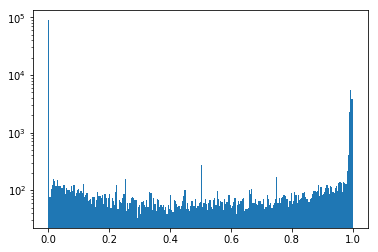

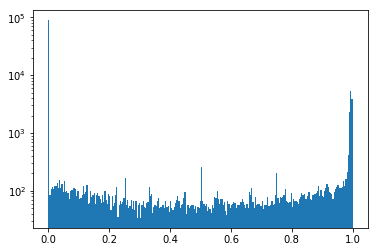

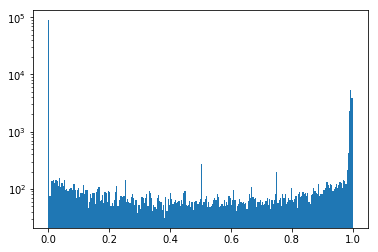

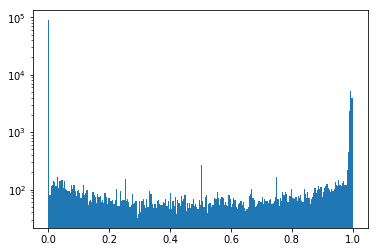

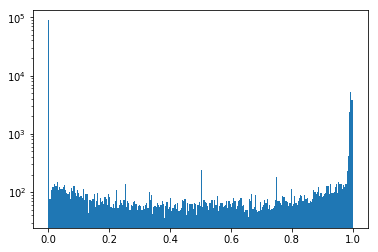

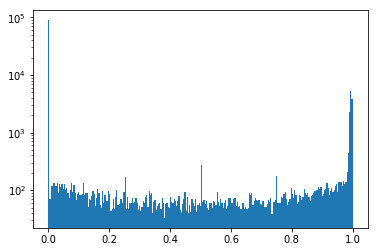

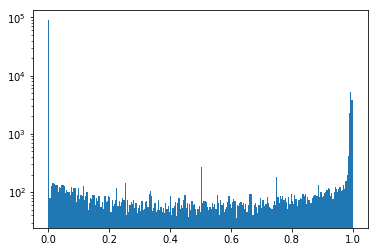

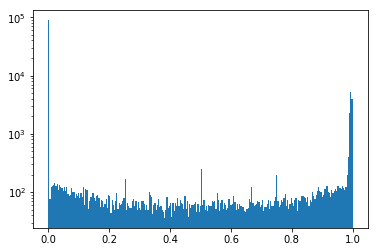

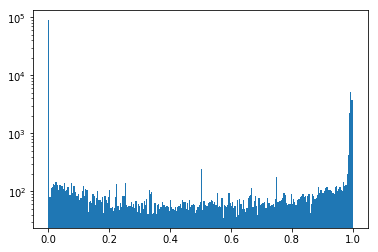

In [157]:
plt.close()
pdfs = []
for ii in range(14):
    plt.figure()
    pdf, _, _ = plt.hist(xp[:, ii], bins=np.linspace(0, 1, 256))
    print(xp[:, ii].mean(), xp[:, ii].std())
    pdfs.append(pdf)
    plt.yscale('log')

In [158]:
im = np.zeros((14, 14))
im2 = np.zeros((14, 14))
for ii in range(14):
    for jj in range(ii):
        im[ii, jj] = entropy(pdfs[ii], pdfs[jj])
        im2[ii,jj] = np.dot(xp[:,ii,0]-xp[:,ii,0].mean(), xp[:,jj]-xp[:,jj].mean())

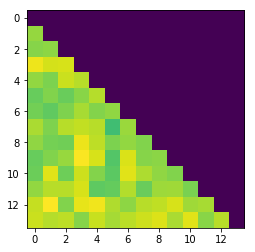

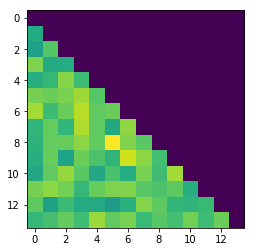

In [160]:
plt.imshow(im)
plt.figure()
plt.imshow(im2)